In [2]:
import math
import random
import time
import matplotlib.pyplot as plt 
import datetime
from multiprocessing import Pool
from itertools import combinations, product
from statistics import mean, stdev
from itertools import combinations
from numpy import log, append, setdiff1d, array
from collections import deque # Cola FIFO para la lista tabú
from numpy import argsort # Ordenar lista por indices (GRASP)

from itertools import tee
verbose = False

# Funciones comunes

In [3]:
def leeFichero(nombreFichero ='tsp/a280.tsp'):
    rutaFichero = './tsp/'
    extension = '.tsp'
    fichero = open(rutaFichero + nombreFichero + extension, 'r')
    array_puntos = []

    # Saltamos las cabeceras del fichero #
    for i in range(6):
        fichero.readline()

    for line in fichero:
        try:
            array_temp = line.replace('   ', ' ').replace('  ', ' ').replace('\n', '').split(' ')
            array_temp = [float(item) for item in array_temp if item]

            if(len(array_temp) > 1):
                array_puntos.append(array_temp)
        except:
            pass

    fichero.close()

    return array_puntos

In [4]:
def getDistancia(p1, p2):
    xd = p1[1] - p2[1]
    yd = p1[2] - p2[2]
    
    dij = round(math.sqrt(xd*xd + yd*yd))
    
    return dij

In [5]:
def getMDistancias(nodos):
   
    distancias = [[0]*len(nodos) for i in range(len(nodos))]
    
    for i in range(len(nodos)):
        for j in range(len(nodos)):
            
            if(i==j):
                dij = 0 # Distancia a sí mismo infinita
            else:
                dij = getDistancia(nodos[i], nodos[j])
                
            distancias[i][j] = dij
            
    return distancias

In [6]:
def pintaCamino(camino, nodos, titulo):
    
    x = []
    y = []
    
    for i in range(0, len(camino)-1):
        
        x.append(nodos[camino[i]-1][1])
        y.append(nodos[camino[i]-1][2])
        
    plt.figure(figsize=(12,12))    
    plt.title(titulo)
    plt.scatter(x, y, color='green') 
    
    for i in range(len(x)):
        if(i < len(x)-1):
            plt.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i], head_width=1, length_includes_head=True)
        else:
             plt.arrow(x[i], y[i], x[0] - x[i], y[0] - y[i], head_width=1, length_includes_head=True)
                
    # Punto rojo inicial
    plt.plot(x[0],y[0], marker='o',
     markerfacecolor='red', markersize=12)
                

In [7]:
def getCosteCamino(camino, distancias, verbose=False):
    coste = 0
    
    for i in range(0, len(camino)-1):
        dij = distancias[camino[i]][camino[i+1]]
        coste += dij # Sumamos la distancia de un nodo al siguiente
        if(verbose):
            print(f"Acumulando Distancia {camino[i]} -> {camino[i+1]} = {dij}")
        
        
    dij = distancias[camino[-1]][camino[0]] #Sumamos la distancia del ultimo al primero
    coste += dij
    if(verbose):
            print(f"Acumulando Distancia {camino[-1]} -> {camino[0]} = {dij}")
    
    return coste

In [8]:
def getCostePivotes(distancias, caminoAnt, costeAnt, piv1, piv2):
      
    caminoAnt1 = [caminoAnt[piv1-1], caminoAnt[piv1]]
    if(piv1 != len(distancias)-1):
        caminoAnt1.append(caminoAnt[piv1+1])
    else:
        # Pivote es el último elemento: último al primero
        caminoAnt1.append(caminoAnt[0])
        
    caminoAnt2 = [caminoAnt[piv2-1], caminoAnt[piv2]]
    if(piv2 != len(distancias)-1):
        caminoAnt2.append(caminoAnt[piv2+1])
    else:
        # Pivote es el último elemento: último al primero
        caminoAnt2.append(caminoAnt[0])
        
    caminoNuevo1 = caminoAnt1.copy()
    if caminoAnt[piv2] in caminoNuevo1:
        caminoNuevo1[caminoNuevo1.index(caminoAnt[piv2])] = caminoAnt[piv1]
    caminoNuevo1[1] = caminoAnt[piv2]
    
    
    caminoNuevo2 = caminoAnt2.copy()
    if caminoAnt[piv1] in caminoNuevo2:
        caminoNuevo2[caminoNuevo2.index(caminoAnt[piv1])] = caminoAnt[piv2]
    caminoNuevo2[1] = caminoAnt[piv1]
   
    #print("SubCaminos anteriores: ", caminoAnt1, caminoAnt2)
    #print("SubCaminos nuevos: ", caminoNuevo1, caminoNuevo2)
    
    return (costeAnt - distancias[caminoAnt1[0]][caminoAnt1[1]] - distancias[caminoAnt1[1]][caminoAnt1[2]] - distancias[caminoAnt2[0]][caminoAnt2[1]] - distancias[caminoAnt2[1]][caminoAnt2[2]] + distancias[caminoNuevo1[0]][caminoNuevo1[1]] +  distancias[caminoNuevo1[1]][caminoNuevo1[2]] + distancias[caminoNuevo2[0]][caminoNuevo2[1]] + distancias[caminoNuevo2[1]][caminoNuevo2[2]])
    

In [9]:
# Algoritmo Greedy
def algoritmoGreedy(distancias):
    
    caminoSolucion = [0] # Empezamos en el primer indice de nodo
    nodosPendientes = list(range(1,len(distancias[1]))) # Lista del segundo al ultimo indice de nodo
    
    while len(nodosPendientes) > 0: # Mientras queden nodos por visitar

        nodoActual = caminoSolucion[-1] # Partimos desde el útlimo nodo añadido
        minDistancia = distancias[nodoActual][nodosPendientes[0]] # Inicializamos la distancia del actual al primer pendiente
        nodoMinDistancia = nodosPendientes[0]
        
        for nodoVecino in nodosPendientes: # Recorremos todos los nodos pendientes y nos quedamos con el de menor distancia
            d = distancias[nodoActual][nodoVecino]
            
            if d < minDistancia:
                minDistancia = d
                nodoMinDistancia = nodoVecino
                
        caminoSolucion.append(nodoMinDistancia)
        nodosPendientes.remove(nodoMinDistancia)
        
    return caminoSolucion
    #return [indice+1 for indice in caminoSolucion] # + 1 a cada elemento (tiene que empezar por 1)

In [10]:
def plt_dynamic(fig, x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()


# Estructura de datos

In [11]:
class Hormiga:
    
    # Métodos de clase
    def set_nodos_distancias(num_nodos, distancias):
        Hormiga.num_nodos = num_nodos
        Hormiga.distancias = distancias
    
    # Métodos de instancias
    
    # Operador minimo
    # https://stackoverflow.com/questions/3621826/python-minimum-of-a-list-of-instance-variables
    def __lt__(self, other):
        return self.coste < other.coste
    
    def __eq__(self, other):
        return self.camino == other.camino
    
    def __str__(self):
        return str(self.coste) 
    
    def __repr__(self):
        return str(self.coste)
    
    def __init__(self, *args):
        
        if not Hormiga.num_nodos or not Hormiga.distancias:
            raise TypeError("No se ha inicializado el num nodos o las distancias para la clase Hormiga") 
        
        if len(args) == 0 or len(args) == 1 and args[0]==None:
            # Hormiga con nodo inicial aleatorio
            self.camino = [random.randint(0,Hormiga.num_nodos-1)]
            self.coste = 0
            
        elif len(args) == 1:
            # Hormiga con nodo inicial
            self.camino = [args[0]]
            self.coste = 0
            
        elif len(args) == 2:
            self.camino = args[0]
            self.coste = args[1]        
        else:
            raise TypeError("Número de argumentos no válido, solo 0 ó 2") 
            
    def add(self, nodo):
        self.coste += self.distancias[self.camino[-1]][nodo]
        self.camino.append(nodo)
       

# Funciones

In [12]:
# https://stackoverflow.com/questions/4113307/pythonic-way-to-select-list-elements-with-different-probability
# https://www.geeksforgeeks.org/bisect-algorithm-functions-in-python/
#import random
import bisect
#import collections

# Devuelve una suma acumulativa de los pesos
def cdf(weights):
    total = sum(weights)
    result = []
    cumsum = 0
    for w in weights:
        cumsum += w
        result.append(cumsum / total)
    return result

def eligeProbabilidad(population, weights):
    assert len(population) == len(weights) # Comprobar mismo tamaño
    cdf_vals = cdf(weights) # Suma acumulativa de los pesos
    x = random.random() 
    idx = bisect.bisect(cdf_vals, x) # Índice donde insertar el número aleatorio
    return population[idx] # Elemento elegido según probabilidad

# weights=[0.3, 0.4, 0.3]
# population = 'ABC'
# counts = collections.defaultdict(int)
# for i in range(10000):
#     counts[choice(population, weights)] += 1
# print(counts)

# # % test.py
# # defaultdict(<type 'int'>, {'A': 3066, 'C': 2964, 'B': 3970})
def regla_transicion(hormiga, feromona, heuristica, alpha, beta):
    
    no_visitados = [x for x in list(range(Hormiga.num_nodos)) if x not in hormiga.camino]      
    probabilidades = []
    
    # CALCULO DE PROBABILIDAD DE TRANSICIÓN 
    # Por cada nodo
    for s in range(Hormiga.num_nodos):  
        
        # Nodo ya visitado
        if s in hormiga.camino:
            probabilidades.append(0)
        # Nodo no visitado
        else:
            num = feromona[hormiga.camino[-1]][s]**alpha * heuristica[hormiga.camino[-1]][s]**beta
            den = 0
            # Acumulamos el sumatorio de los nodos no visitados
            for u in range(Hormiga.num_nodos):
                if u not in hormiga.camino:
                    den += feromona[hormiga.camino[-1]][u]**alpha * heuristica[hormiga.camino[-1]][u]**beta
            
            probabilidades.append(num/den)
        
    # Elegimos uno de los nodos con la probabilidad calculada
    return eligeProbabilidad(list(range(Hormiga.num_nodos)), probabilidades)
    

In [13]:
# https://stackoverflow.com/questions/33116880/how-do-i-check-if-two-consecutive-numbers-integers-in-a-list-have-the-same-val
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def contiene_arco(hormiga, r, s):
    for a, b in pairwise(hormiga.camino):
        if a == r and b==s:
            return True
    return False

In [14]:
def actualizacion_feromona(valor_actual, hormigas, evaporacion, r, s):
    
    termino_evap = (1 - evaporacion) * valor_actual
    
    termino_aporte = 0
    for i in range(len(hormigas)):
        if contiene_arco(hormigas[i], r,s):
            termino_aporte += 1 / hormigas[i].coste
        # Si no, cero
    
    return termino_evap + termino_aporte
            

# Algoritmo

In [15]:
def algoritmo_SH(semilla, num_nodos, distancias, num_hormigas, num_iteraciones, feromona_ini, heuristica, alpha, beta, evaporacion, nodo_inicial=None):
    
    # Aplicamos la semilla
    random.seed(semilla)
    
    # Representacion
    xs, ys = [], []
    
    # Inicializamos los atributos de la clase Hormiga
    Hormiga.num_nodos = num_nodos
    Hormiga.distancias = distancias
    
    # Inicializamos la matriz de feromonas
    feromona = [[feromona_ini]*len(nodos) for i in range(len(nodos))]
    
    mejor_global = None
    for it in range(num_iteraciones):
        
        # Inicializamos las hormigas al nodo inicial
        hormigas = []
        for k in range(num_hormigas):
            hormigas.append(Hormiga(nodo_inicial))
        
        # Construcción de soluciones por las hormigas
        for i in range(num_hormigas):
            for k in range(num_nodos-1):
                # Añadimos el nodo resultante de aplicar la regla de transición
                hormigas[i].add(regla_transicion(hormigas[i], feromona, heuristica, alpha, beta))
            
        # Actualización de feromona: Aporte y evaporación
        for i in range(num_nodos):
            for j in range(num_nodos):
                feromona[i][j] = actualizacion_feromona(feromona[i][j], hormigas, evaporacion, i, j)
                
        # Actualización de la mejor solucion global
        mejor_actual = min(hormigas)

        if mejor_global is None or mejor_actual < mejor_global:
            mejor_global = mejor_actual
            
        # Representación
        xs.append(it)
        ys.append(mejor_global.coste)
            
    return [mejor_global, semilla, xs, ys]

In [18]:
# Hormiga.num_nodos = 70
# Hormiga.distancias = distancias
# hormiga = Hormiga()

# h2 = Hormiga(0)
# for x in range(Hormiga.num_nodos):
#      if x not in h2.camino:
#             h2.add(x)
# print(h2)
# print(h2.camino)

3390
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


Sistema de Hormigas


ZeroDivisionError: float division by zero

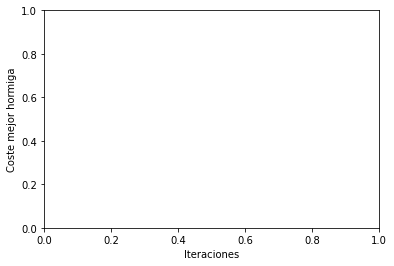

<Figure size 864x864 with 0 Axes>

In [17]:
%matplotlib notebook
%matplotlib inline
fig, ax = plt.subplots(1,1)
plt.figure(figsize=(12,12)) 
ax.set_xlabel('Iteraciones') ; ax.set_ylabel('Coste mejor hormiga')

algoritmo = "Sistema de Hormigas"
print(algoritmo)
fichero = "st70"
nodos = leeFichero(fichero)
num_nodos = len(nodos)    # Fichero
distancias = getMDistancias(nodos)
semilla = random.randint(0,9999999)

# PARAMETROS DEL ALGORITMO
num_hormigas = 10
num_iteraciones = 10000 * num_nodos
feromona_ini = 1 / (num_nodos * getCosteCamino(algoritmoGreedy(distancias), distancias))
alpha = 1
beta = 2
evaporacion = 0.1

# Iniciamos la heuristica 1/d
heuristica = []
for row in range(len(distancias)):
    heuristica.append([1/(x+0.01) for x in distancias[row]])

t = time.time()

# with Pool(processes=6) as p:
#        resultados = p.starmap(algoritmo_SH, product([semilla], [num_nodos], [distancias], [num_hormigas], [feromona_ini], [heuristica], [alpha], [beta], [evaporacion]))[0]


resultados = algoritmo_SH(semilla, num_nodos, distancias, num_hormigas, num_iteraciones, feromona_ini, heuristica, alpha, beta, evaporacion)

elapsed = time.time() - t
print("Tiempo de ejecución: %f\n" % elapsed )

coste = resultados[0].coste

print("Mejor sol Coste: %s \t Semilla: %s" % (coste, semilla) ) 

xs = resultados[2]
ys = resultados[3]

plt_dynamic(fig, xs, ys, ax)


titulo = algoritmo + " - Mejor solución " + fichero + ": " + str(coste)
pintaCamino(resultados[0].camino, nodos, titulo)

True